In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import jaccard_score
import os
from sklearn.svm import l1_min_c
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score as cvs
import sys
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from tabulate import tabulate

In [79]:
#os.chdir(os.pardir)
np.set_printoptions(threshold=sys.maxsize)

In [80]:
k_mer = "6"
pca_check = False

In [81]:
Windows = True

if Windows:
    path = "processed_data\combined_data\split_with_background\\"+k_mer + "mers_extend200\\"
else:
    path = "processed_data/combined_data/split_with_background/"+k_mer+"mers_extend200/"

meth_even = pd.read_csv(path + "combined_" + k_mer + "mers_meth_even_with_background.tsv", sep="\t")
meth_odd = pd.read_csv(path +"combined_"+k_mer+"mers_meth_odd_with_background.tsv", sep="\t")
unmeth_even = pd.read_csv(path + "combined_"+k_mer+"mers_unmeth_even_with_background.tsv", sep="\t")
unmeth_odd = pd.read_csv(path + "combined_"+k_mer+"mers_unmeth_odd_with_background.tsv", sep="\t")


meth_even_healthy = meth_even.loc[meth_even["cancer"]=="Healthy"]

meth_even_unhealthy = meth_even.loc[meth_even["cancer"]!="Healthy"]

meth_odd_healthy = meth_odd.loc[meth_odd["cancer"]=="Healthy"]

meth_odd_unhealthy = meth_odd.loc[meth_odd["cancer"]!="Healthy"]

unmeth_even_healthy = unmeth_even.loc[unmeth_even["cancer"]=="Healthy"]

unmeth_even_unhealthy = unmeth_even.loc[unmeth_even["cancer"]!="Healthy"]

unmeth_odd_healthy = unmeth_odd.loc[unmeth_odd["cancer"]=="Healthy"]

unmeth_odd_unhealthy = unmeth_odd.loc[unmeth_odd["cancer"]!="Healthy"]

meth_even_healthy = meth_even_healthy.drop(306)

meth_odd_healthy = meth_odd_healthy.drop(306)

unmeth_even_healthy = unmeth_even_healthy.drop(306)

unmeth_odd_healthy = unmeth_odd_healthy.drop(306)




#index to get get half the healthy 
tr = np.shape(meth_odd_healthy)[0]//2

# Training data 

tr_meth_even_healthy = meth_even_healthy[0:tr]

tr_meth_odd_healthy = meth_odd_healthy[0:tr]

tr_unmeth_even_healthy = unmeth_even_healthy[0:tr]

tr_unmeth_odd_healthy = unmeth_odd_healthy[0:tr]

# Test data 

test_meth_even_healthy = meth_even_healthy[tr:]

test_meth_odd_healthy = meth_odd_healthy[tr:]

test_unmeth_even_healthy = unmeth_even_healthy[tr:]

test_unmeth_odd_healthy = unmeth_odd_healthy[tr:]


# Matrices

train_matrix = [tr_meth_even_healthy, tr_meth_odd_healthy, tr_unmeth_even_healthy, tr_unmeth_odd_healthy]

pred_matrix = [test_meth_odd_healthy, test_meth_even_healthy, test_unmeth_even_healthy, test_unmeth_odd_healthy, meth_even_unhealthy, meth_odd_unhealthy, unmeth_even_unhealthy, unmeth_odd_unhealthy]

train_matrix = pd.concat(train_matrix) 
train_matrix = train_matrix.iloc[: , :-1]

pred_matrix = pd.concat(pred_matrix) 
pred_matrix = pred_matrix.iloc[: , :-1]



train_targets = [0] * np.shape(tr_meth_even_healthy)[0] + [0] * np.shape(tr_meth_odd_healthy)[0] +  [1] * np.shape(tr_unmeth_even_healthy)[0] + [1] * np.shape(tr_unmeth_odd_healthy)[0] 

pred_targets = [0] * np.shape(test_meth_even_healthy)[0] + [0] * np.shape(test_meth_odd_healthy)[0] +  [1] * np.shape(test_unmeth_even_healthy)[0] + [1] * np.shape(test_unmeth_odd_healthy)[0] + [0] * np.shape(meth_even_unhealthy)[0] +   [0] * np.shape(meth_odd_unhealthy)[0] +  [1] * np.shape(unmeth_even_unhealthy)[0] +  [1] * np.shape(unmeth_odd_unhealthy)[0]


In [82]:
def pca(train_data, test_data, n_comp): 
    dim_reduction = PCA(n_components= n_comp)
    train_fit = dim_reduction.fit_transform(train_data)
    test_fit = dim_reduction.transform(test_data)
    return [train_fit, test_fit]



c:\Users\dwarf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9943312532892264


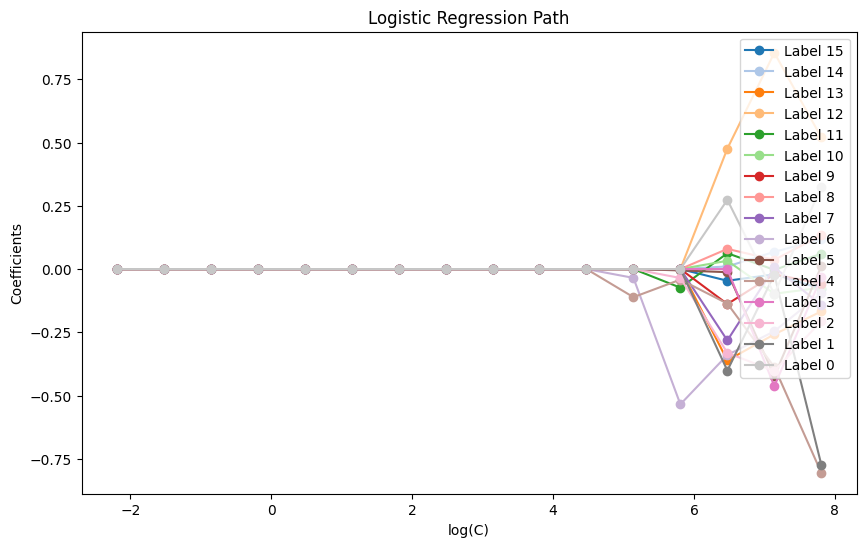

In [83]:
if pca_check == True:
    train_fit, test_fit = pca(train_matrix, pred_matrix, n_comp=np.shape(train_matrix)[0])
else:
    train_fit, test_fit = train_matrix, pred_matrix

cs = l1_min_c(train_fit, train_targets, loss = 'log') * np.logspace(0,10,16)

empty_model = LR(penalty = 'l1',solver='liblinear',tol=1e-6,max_iter=100,warm_start=True,intercept_scaling=10000.0)

coefs_ = []
for c in cs:
    empty_model.set_params(C=c)
    empty_model.fit(train_fit, train_targets)
    coefs_.append(empty_model.coef_.ravel().copy())
coefs_ = np.array(coefs_)

preds = empty_model.predict_proba(test_fit)



score = cvs(empty_model, preds, pred_targets)
print(score.mean())

labels = list(range(16))
labels = labels[::-1]


colormap = plt.cm.get_cmap('tab20')

plt.figure(figsize=(10, 6))

for i, label in zip(range(len(labels)), labels):
    plt.plot(np.log10(cs), coefs_[:, i], marker="o", label=f"Label {label}", color=colormap(i))

ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.legend()
plt.show()


Text(0, 0.5, 'True positive rate')

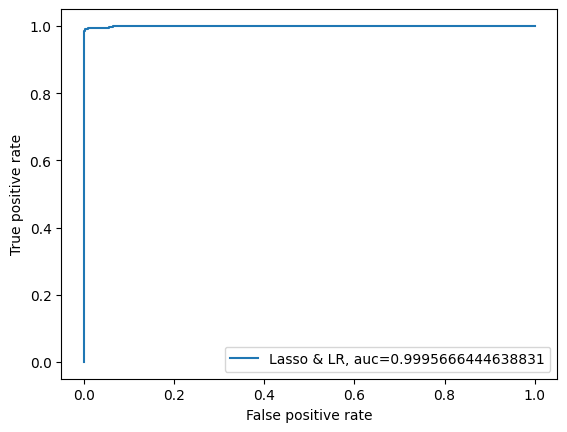

In [84]:
roc_score= roc_auc_score(pred_targets, preds[:, 1])

fpr, tpr, _ = metrics.roc_curve(pred_targets,  preds[:, 1])

ROC = [[fpr,tpr],roc_score]
results.append(ROC)
plt.plot(fpr,tpr,label="Lasso & LR, auc="+str(roc_score))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [88]:
table_data = [["2-mer PCA", results[0][1]],
              ["2-mer norm", results[1][1]],
              ["4-mer PCA", results[2][1]],
              ["4-mer norm", results[3][1]],
              ["6-mer PCA", results[4][1]],
              ["6-mer norm", results[5][1]]]
col_names = ["K-mer","ROC score"]
print(tabulate(table_data,headers=col_names))

K-mer         ROC score
----------  -----------
2-mer PCA      0.981177
2-mer norm     0.905514
4-mer PCA      0.996577
4-mer norm     0.987976
6-mer PCA      0.999996
6-mer norm     0.999567


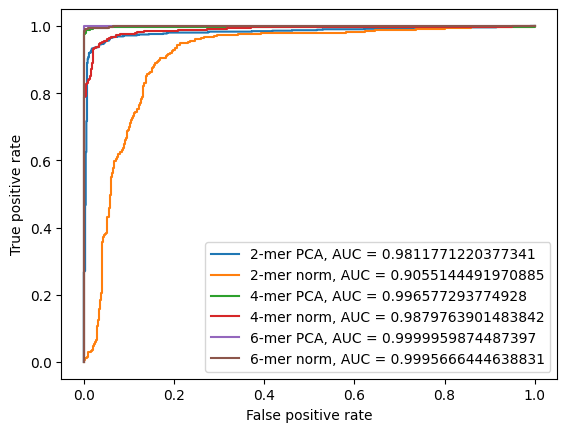

In [96]:
for i in range(len(results)):
    plt.plot(results[i][0][0],results[i][0][1],label=table_data[i][0] + ", AUC = " + str(table_data[i][1]))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("ROC_curves")

In [86]:
#results = []